In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def read_data(test=False):
    if test:
        input_file = pd.read_csv('./input/face/test.csv')
    else:
        input_file = pd.read_csv('./input/face/training.csv')
    cols = input_file.columns[:-1]
    
    input_file = input_file.dropna()  
    input_file['Image'] = input_file['Image'].apply(lambda img: np.fromstring(img, sep=' ') / 255.0)
    X = np.vstack(input_file['Image'])
    X = X.reshape((-1,96,96,1))
    
    if test:
        Y = None
    else:
        Y = input_file[cols].values / 96.0 
    return X,Y

In [3]:
keypoint_index = {
        'left_eye_center_x':0,
        'left_eye_center_y':1,
        'right_eye_center_x':2,
        'right_eye_center_y':3,
        'left_eye_inner_corner_x':4,
        'left_eye_inner_corner_y':5,
        'left_eye_outer_corner_x':6,
        'left_eye_outer_corner_y':7,
        'right_eye_inner_corner_x':8,
        'right_eye_inner_corner_y':9,
        'right_eye_outer_corner_x':10,
        'right_eye_outer_corner_y':11,
        'left_eyebrow_inner_end_x':12,
        'left_eyebrow_inner_end_y':13,
        'left_eyebrow_outer_end_x':14,
        'left_eyebrow_outer_end_y':15,
        'right_eyebrow_inner_end_x':16,
        'right_eyebrow_inner_end_y':17,
        'right_eyebrow_outer_end_x':18,
        'right_eyebrow_outer_end_y':19,
        'nose_tip_x':20,
        'nose_tip_y':21,
        'mouth_left_corner_x':22,
        'mouth_left_corner_y':23,
        'mouth_right_corner_x':24,
        'mouth_right_corner_y':25,
        'mouth_center_top_lip_x':26,
        'mouth_center_top_lip_y':27,
        'mouth_center_bottom_lip_x':28,
        'mouth_center_bottom_lip_y':29
    }

In [4]:
def save_model(saver, sess, save_path):
    path = saver.save(sess, save_path)
    print('model save in :{0}'.format(path))
    

In [5]:
channel_1 = 16
channel_2 = 32
channel_3 = 64
channel_4 = 128
channel_5 = 256
x = tf.placeholder(tf.float32, shape = [None,96,96,1])
y = tf.placeholder(tf.float32, shape = [None, 30])
keep_prob = tf.placeholder(tf.float32)
def conv(x,channel_size):
    initializer = tf.variance_scaling_initializer(scale=2.0)
    return tf.layers.conv2d(x,channel_size,(3,3),(1,1),"same",
                                      activation=tf.nn.relu,use_bias=True,kernel_initializer=initializer,bias_initializer=tf.zeros_initializer())
def max_pooling(x):
    return tf.layers.max_pooling2d(inputs=x, pool_size=[2, 2], strides=2)
def bn(x,is_training):
    return tf.layers.batch_normalization(x,training=is_training)


def model(x):
    #conv1_w = tf.Variable(tf.truncated_normal([3, 3, 1, 16], stddev=0.1))
    #conv1_b = tf.Variable(tf.constant(0.1, shape=[16]))
    initializer = tf.variance_scaling_initializer(scale=2.0)
    conv1 = conv(x, channel_1)
    #bn1 = bn(conv1,True)
    
    conv2 = conv(conv1, channel_2)
    #bn2 = bn(conv2, True)
    max_pool1 = max_pooling(conv2)
    
    conv3 = conv(max_pool1, channel_3)
    #bn3 = bn(conv3, True)
    
    conv4 = conv(conv3, channel_4)
    #bn4 = bn(conv4, True)
    max_pool2 = max_pooling(conv4)
    
    conv5 = conv(max_pool2, channel_5)
    #bn5 = bn(conv5, True)
    
    flat = tf.layers.flatten(conv5)
    dense1 = tf.layers.dense(flat,500, activation=tf.nn.relu, kernel_initializer=initializer,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    dense2 = tf.layers.dense(dense1,500, activation=tf.nn.relu, kernel_initializer=initializer,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    dense3 = tf.layers.dense(dense2,30, kernel_initializer=initializer,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    return dense3

In [6]:
VALIDATION_SIZE = 100    #验证集大小
EPOCHS = 20             #迭代次数
BATCH_SIZE = 100          #每个batch大小，稍微大一点的batch会更稳定
EARLY_STOP_PATIENCE = 10 #控制early stopping的参数
device = '/gpu:0'

X,Y = read_data()
X_valid, Y_valid = X[:VALIDATION_SIZE], Y[:VALIDATION_SIZE]
X_train, Y_train = X[VALIDATION_SIZE:], Y[VALIDATION_SIZE:]
TRAIN_SIZE = X_train.shape[0]

In [7]:
result_y = model(x)
loss = tf.sqrt(tf.reduce_mean(tf.square(y - result_y)))
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for epoch in range(EPOCHS + 1):
    print('epoch %d start:'% epoch)
    for i in range(0,TRAIN_SIZE,BATCH_SIZE):
        sess.run(train_step, feed_dict={x:X_train[i:i+BATCH_SIZE], y:Y_train[i:i+BATCH_SIZE]})
        if i % 100 == 0:
            train_loss = sess.run(loss, feed_dict={x:X_train[i:i+BATCH_SIZE], y:Y_train[i:i+BATCH_SIZE]})
    print('training loss is %f.' % train_loss)

epoch 0 start:
training loss is 0.105578.
epoch 1 start:
training loss is 0.058558.
epoch 2 start:
training loss is 0.038231.
epoch 3 start:
training loss is 0.035228.
epoch 4 start:
training loss is 0.032807.
epoch 5 start:
training loss is 0.028812.
epoch 6 start:
training loss is 0.028625.
epoch 7 start:
training loss is 0.033381.
epoch 8 start:
training loss is 0.022405.
epoch 9 start:
training loss is 0.025843.
epoch 10 start:
training loss is 0.025781.
epoch 11 start:
training loss is 0.028785.
epoch 12 start:
training loss is 0.019438.
epoch 13 start:
training loss is 0.031513.
epoch 14 start:
training loss is 0.016154.
epoch 15 start:
training loss is 0.019461.
epoch 16 start:
training loss is 0.026203.
epoch 17 start:
training loss is 0.036961.
epoch 18 start:
training loss is 0.037214.
epoch 19 start:
training loss is 0.023748.
epoch 20 start:
training loss is 0.017532.


In [8]:
X,y = read_data(test=True)
y_pred = []

TEST_SIZE = X.shape[0]
for j in range(0,TEST_SIZE,BATCH_SIZE):
    y_batch = sess.run(result_y,feed_dict={x:X[j:j+BATCH_SIZE]})
    y_pred.extend(y_batch)

print('Image wrote done')

output_file = open('./input/face/submit.csv','w')
output_file.write('RowId,Location\n')

IdLookupTable = open('./input/face/IdLookupTable.csv')
IdLookupTable.readline()

for line in IdLookupTable:
    RowId,ImageId,FeatureName = line.rstrip().split(',')
    image_index = int(ImageId) - 1
    feature_index = keypoint_index[FeatureName]
    feature_location = y_pred[image_index][feature_index] * 96
    output_file.write('{0},{1}\n'.format(RowId,feature_location))

output_file.close()
IdLookupTable.close()


Image wrote done


[0.6707812  0.3804943  0.3412351  0.38671377 0.61412174 0.40837282
 0.7254706  0.38295484 0.4172225  0.42951635 0.30035377 0.38250336
 0.60010827 0.34857875 0.7708501  0.307548   0.4425795  0.3295885
 0.24105605 0.3268652  0.53468347 0.63953733 0.65999305 0.7432138
 0.3521084  0.75000143 0.5260215  0.772368   0.5293968  0.75459677]


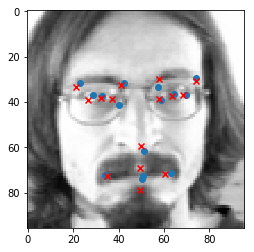

In [9]:
def plot_sample(x, y, truth=None):
    img = x.reshape(96, 96)
    plt.imshow(img, cmap='gray')
    if y is not None:
        plt.scatter(y[0::2] * 96, y[1::2] * 96)
    if truth is not None:
        plt.scatter(truth[0::2] * 96, truth[1::2] * 96, c='r', marker='x')
    plt.savefig("./input/img.png")
    
i = 52
img = X_valid[i]
test_x = img.reshape(-1,96,96,1)
lab_y = Y_valid[i]
pred_y = sess.run(result_y,feed_dict={x:test_x}).reshape(-1)
print(pred_y)

plot_sample(img,pred_y,lab_y)